# RNN LSTM MultiClass Classifier for Openpose (pose,hand,face) Keypoints

- Author: Srini Ananthakrishnan
- Date  : 09/08/2017

### Import packages

In [1]:
import IPython
import pandas as pd
import keras
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, TimeDistributed, Activation
from keras.layers import LSTM
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from kerasify import export_model
from keras.models import model_from_json
import os

### Model Parameters and Paths

### NOTE: Uncomment below cell to generate one of the classifier model (hand or pose or face)

In [3]:
timesteps = 5

## POSE - val_acc: 98%
epochs = 1000
batch_size = 32
_dropout = 0.1
_activation='relu'
_optimizer='Adam'
class_names = ["close_to_camera","standing","sitting"]
X_vector_dim = 36 # number of features or columns (pose)
samples_path = "../../../train_data/pose/pose_samples_raw.txt"
labels_path = "../../../train_data/pose/pose_labels_raw.txt"
model_path = '../../../train_data/pose/pose.model'
json_model_path = '../../../train_data/pose/pose_model.json'
model_weights_path = "../../../train_data/pose/pose_model.h5"

# ## HAND - val_acc: 97%
# epochs = 1000
# batch_size = 32
# _dropout = 0.1
# _activation='relu'
# _optimizer='adam'
# class_names = ["fist","pinch","wave","victory","stop","thumbsup"]
# X_vector_dim = 40 # number of features or columns (hand)
# samples_path = "../../../train_data/hand/hand_samples_raw.txt"
# labels_path = "../../../train_data/hand/hand_labels_raw.txt"
# model_path = '../../../train_data/hand/hand.model'
# json_model_path = '../../../train_data/hand/hand_model.json'
# model_weights_path = "../../../train_data/hand/hand_model.h5"

# # ## FACE - val_acc: 96%
# epochs = 1000
# batch_size = 32
# _dropout = 0.1
# _activation='tanh'
# _optimizer='Adadelta'
# class_names = ["normal","happy","sad","surprise"]
# X_vector_dim = 96 # number of features or columns (face)
# samples_path = "../../../train_data/face/face_samples_raw.txt"
# labels_path = "../../../train_data/face/face_labels_raw.txt"
# model_path = '../../../train_data/face/face.model'
# json_model_path = '../../../train_data/face/face_model.json'
# model_weights_path = "../../../train_data/face/face_model.h5"

### Load Keypoints Samples and Labels

In [4]:
X = np.loadtxt(samples_path, dtype="float")

In [5]:
y = np.loadtxt(labels_path)

In [6]:
X.shape, y.shape

((311, 180), (311,))

In [7]:
def samples_to_3D_array(_vector_dim, _vectors_per_sample, _X):
    X_len = len(_X)
    result_array = []
    for sample in range (0,X_len):
        sample_array = []
        for vector_idx in range (0, _vectors_per_sample):
            start = vector_idx * _vector_dim
            end = start + _vector_dim
            sample_array.append(_X[sample][start:end])
        result_array.append(sample_array) 

    return np.asarray(result_array)

#### Keras LSTM model require 3-Dimensional Tensors. Let's convert samples to 3D tensors !!

In [8]:
X_vectors_per_sample = timesteps # number of vectors per sample
X_3D = samples_to_3D_array(X_vector_dim, X_vectors_per_sample, X)

In [9]:
X_3D.shape

(311, 5, 36)

#### Converst y integer labels (0,1,2..) to one_hot_encoding vectors 

In [10]:
def convert_y_to_one_hot(_y):
    _y = np.asarray(_y,dtype=int)
    b = np.zeros((_y.size, _y.max()+1))
    b[np.arange(_y.size),_y] = 1
    return b

In [12]:
y_one_hot = convert_y_to_one_hot(y)
y_one_hot.shape

(311, 4)

In [14]:
y_vector_dim = y_one_hot.shape[1] # number of features or columns

### Test-Train Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_3D, y_one_hot, test_size=0.33, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208, 5, 36), (103, 5, 36), (208, 4), (103, 4))

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

(5, 36)

### Build Keras TimeDistributed(Dense) (many-to-many case) LSTM model

In [18]:
print "Model Parameters:"
print "input_shape     : ", input_shape
print "X_vector_dim    : ", X_vector_dim
print "y_vector_dim    : ", y_vector_dim

Model Parameters:
input_shape     :  (5, 36)
X_vector_dim    :  36
y_vector_dim    :  4


In [19]:
print ("Build Keras Timedistributed-LSTM Model...")
model = Sequential()
model.add(TimeDistributed(Dense(X_vector_dim, activation=_activation), input_shape=input_shape))
model.add(Dropout(_dropout))
model.add(TimeDistributed(Dense(X_vector_dim*2, activation=_activation))) #(5, 80)
model.add(Dropout(_dropout))
model.add(TimeDistributed(Dense(X_vector_dim, activation=_activation))) #(5, 40)
model.add(Dropout(_dropout))
model.add(TimeDistributed(Dense(X_vector_dim/2, activation=_activation))) #(5, 20)
model.add(Dropout(_dropout))
model.add(TimeDistributed(Dense(X_vector_dim/4, activation=_activation))) #(5, 10)
model.add(Dropout(_dropout))
model.add(LSTM(X_vector_dim/4, dropout=_dropout, recurrent_dropout=_dropout))
model.add(Dense(y_vector_dim,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=_optimizer, metrics=['accuracy'])
model.summary()

# Test-2: 95% val-acc
# model = Sequential()
# model.add(TimeDistributed(Dense(X_vector_dim, activation='relu'), input_shape=input_shape))
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim*2, activation='relu'))) #(5, 80)
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim, activation='relu'))) #(5, 40)
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim/2, activation='relu'))) #(5, 20)
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim/4, activation='relu'))) #(5, 10)
# model.add(Dropout(_dropout))
# model.add(LSTM(X_vector_dim/4, dropout=_dropout, recurrent_dropout=_dropout))
# model.add(Dense(y_vector_dim,activation='softplus'))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# model.summary()

# Test-1: 94% val-acc
# model = Sequential()
# model.add(TimeDistributed(Dense(X_vector_dim, activation='relu'), input_shape=input_shape))
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim*2, activation='relu'))) #(5, 80)
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim, activation='relu'))) #(5, 40)
# model.add(Dropout(_dropout))
# model.add(TimeDistributed(Dense(X_vector_dim/2, activation='relu'))) #(5, 20)
# model.add(Dropout(_dropout))
# model.add(LSTM(X_vector_dim/2, dropout=_dropout, recurrent_dropout=_dropout))
# model.add(Dense(y_vector_dim,activation='softplus'))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# model.summary()

Build Keras Timedistributed-LSTM Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 5, 36)             1332      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 36)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 72)             2664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 72)             0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 36)             2628      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 36)             0         
_________________________________________________________________
time_distributed_4 (TimeDist (None

In [20]:
# Callback class to visialize training progress
class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super(TrainingVisualizer, self).on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        axes = pd.DataFrame(self.history).plot()
        axes.axvline(x=max((val_acc, i) for i, val_acc in enumerate(self.history['val_acc']))[1])
        plt.show()

### Train Model

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((208, 5, 36), (208, 4), (103, 5, 36), (103, 4))

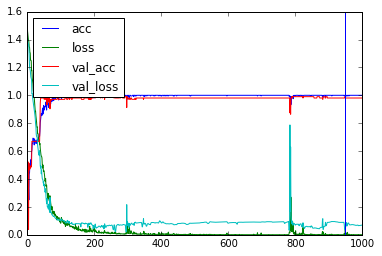

208/208 [==============================] - 0s - loss: 9.1659e-04 - acc: 1.0000 - val_loss: 0.0695 - val_acc: 0.9806


In [22]:
print('Training...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[TrainingVisualizer()])

### Evaluate Model and Predict Classes

In [23]:
print('Testing...')
score, accuracy = model.evaluate(X_test, y_test,
                                 batch_size=batch_size)

Testing...
 32/103 [========>.....................] - ETA: 0s

In [24]:
print('Test score: {:.3}'.format(score))
print('Test accuracy: {:.3}'.format(accuracy))

Test score: 0.0695
Test accuracy: 0.981


In [25]:
X_test.shape, y_test.shape

((103, 5, 36), (103, 4))

In [26]:
y_pred = model.predict(X_test)
y_pred.shape

(103, 4)

### Confusion Matrix

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
y_test[:10]

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

In [29]:
np.argmax(y_test, axis=1)

array([3, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 3, 3, 1, 2, 2, 2, 1, 2, 2,
       3, 1, 2, 2, 1, 3, 3, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2, 1, 1, 2, 3, 3, 2,
       3, 1, 3, 1, 2, 3, 2, 1, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 3, 1, 2, 2, 3, 3, 3, 2, 2, 1, 3, 1, 2, 2, 3, 1, 2,
       1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3])

In [30]:
np.argmax(y_pred, axis=1)

array([3, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 3, 3, 1, 2, 2, 2, 1, 2, 2,
       3, 1, 2, 2, 1, 3, 3, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2, 1, 1, 2, 3, 3, 2,
       3, 1, 3, 1, 2, 3, 2, 1, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 3, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2,
       1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3])

Confusion matrix, without normalization
[[37  0  0]
 [ 0 34  0]
 [ 1  1 30]]


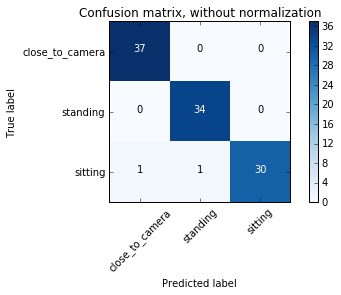

In [31]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

### Export model

In [32]:
export_model(model,model_path)
print("Model saved to disk")

TimeDistributed
Activation:  relu
TimeDistributed
Activation:  relu
TimeDistributed
Activation:  relu
TimeDistributed
Activation:  relu
TimeDistributed
Activation:  relu
Input Dim: 9
Model saved to disk


### serialize model to JSON

In [33]:
# # serialize model to JSON
model_json = model.to_json()
with open(json_model_path, "w") as json_file:
    json_file.write(json_model_path)
# serialize weights to HDF5
model.save_weights(model_weights_path)
print("Saved model to disk")

Saved model to disk


### Sample Test

#### ( eg: Each hand sample is a frame sequence (t0, t1, t2, t3, t4) of 5 vectors each 40 feature dimensions)

In [34]:
test_sample = X_test[20]
print "test_sample shape:",test_sample.shape
test_sample_y_hat = model.predict(test_sample.reshape(1, test_sample.shape[0],test_sample.shape[1]))
test_sample_y_hat.shape

test_sample shape: (5, 36)


(1, 4)

In [35]:
test_sample_y_hat[0]

array([  5.23e-05,   1.00e+00,   2.33e-06,   2.28e-05], dtype=float32)

In [36]:
print "Predicted hand label:", np.argmax(test_sample_y_hat, axis=1)[0]
print "Actual hand label   :", np.argmax(y_test[20])

Predicted hand label: 1
Actual hand label   : 1


## Appendix (Debugging Test Frame)

In [37]:
# _x = "27.3453 0 57.7684 0 0 0 0 0 66.4199 0 89.4026 0 108.107 0 124.934 0 64.7402 0 93.3391 0 115.678 0 136.163 0 63.3009 0 74.4868 0 65.1739 0 0 0 63.1903 0 71.2364 0 61.7355 0 51.5892 0 26.7669 0 56.1333 0 0 0 0 0 63.0563 0 87.9288 0 107.327 0 124.338 0 63.0463 0 93.1842 0 115.99 0 135.202 0 59.6076 0 73.6994 0 71.0425 0 0 0 55.7072 0 74.0841 0 69.9724 0 58.7814 0 27.5654 0 57.1017 0 0 0 0 0 65.1915 0 77.0844 0 94.9881 0 112.067 0 62.1621 0 71.6954 0 88.1963 0 103.701 0 60.9382 0 0 0 0 0 0 0 56.9681 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 58.322 0 84.251 0 104.265 0 121.332 0 59.3682 0 89.1917 0 111.542 0 131.714 0 57.8266 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 64.2498 0 80.8496 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0"

In [38]:
# vector = np.array([float(_) for _ in _x.split(" ")])

In [39]:
# vector

In [40]:
# vectors = vector.reshape((5,40))

In [41]:
# vectors[0,:]

In [42]:
# vectors_y_hat = model.predict(vectors.reshape(1, vectors.shape[0],vectors.shape[1]))
# for i in vectors_y_hat[0]:
#     print '%.32e' % i

In [43]:
# print "Predicted hand label:", np.argmax(vectors_y_hat, axis=1)[0]

### Dump weights

In [44]:
# for layer in range(len(model.layers)):
#     print type(model.layers[layer]).__name__
#     layer_type = type(model.layers[layer]).__name__
#     for e in zip(model.layers[layer].trainable_weights, model.layers[layer].get_weights()):
#         if (1): #(layer_type == 'LSTM'):
#             print('Param %s:\n%d\n%s' % (e[0],len(e[1]),e[1]))

In [45]:
# for layer in range(len(model.layers)):
#     print layer, type(model.layers[layer]).__name__

In [46]:
# weights = model.layers[10].get_weights()
# input_dim = weights[0].shape[1]/4 # 40 in case of hand keypoints

# W_i = weights[0][:,0:input_dim] # [0:40] has input (i)
# U_i = weights[1][:,0:input_dim]
# b_i = weights[2][0:input_dim]

# W_c = weights[0][:,input_dim:(2*input_dim)] # [40:80] has c
# U_c = weights[1][:,input_dim:(2*input_dim)]
# b_c = weights[2][input_dim:(2*input_dim)]

# W_f = weights[0][:,(2*input_dim):(3*input_dim)] # [80:120] has f
# U_f = weights[1][:,(2*input_dim):(3*input_dim)]
# b_f = weights[2][(2*input_dim):(3*input_dim)]

# W_o = weights[0][:,(3*input_dim):(4*input_dim)] # [80:120] has o
# U_o = weights[1][:,(3*input_dim):(4*input_dim)]
# b_o = weights[2][(3*input_dim):(4*input_dim)]

In [47]:
# input_dim

In [48]:
# W_i.shape, W_c.shape, W_f.shape, W_o.shape

In [49]:
# U_i.shape, U_c.shape, U_f.shape, U_o.shape

In [50]:
# b_i.shape, b_c.shape, b_f.shape, b_o.shape